# Dataset structure analysis and parcing initial dataframe

Downloading all nesessary Python libraries for the project.

In [1]:
import collections

import pandas as pd
import numpy as np
import scipy.io

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


from sklearn.model_selection import train_test_split,  StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
import sklearn.pipeline as pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn import metrics

import shap
import xgboost as xgb

In [2]:
%matplotlib inline

In [3]:
file_for_analysis = '/Users/sensogram/Documents/AccDB/AR.mat' #use set of activity
full_data = scipy.io.loadmat(file_for_analysis)

In [4]:
type(full_data)

dict

In [5]:
list(full_data.keys())[:5]

['__header__', '__version__', '__globals__', 'fc_cycling1', 'fc_cycling10']

In [6]:
labels = list(full_data.keys())[7:10] #select 3 random measurements
acc_data = [full_data[label] for label in labels] 

label_ind = 0
#show the structure of data under each key in dict (one measurement)
for label, acc in zip(labels, acc_data):
    print("Label %s: %s \nShape of data under label: %s \n" % 
          (label_ind, label, acc.shape))
    label_ind += 1

Label 0: fc_cycling13 
Shape of data under label: (1, 173) 

Label 1: fc_cycling14 
Shape of data under label: (1, 163) 

Label 2: fc_cycling15 
Shape of data under label: (1, 158) 



In [7]:
#check the length of frames of data
label_ind = 0

for label, acc in zip(labels, acc_data):
    print("Label %s, Label's subsample shape: %s " % 
          (label, acc[0,0].shape))
    label_ind += 1

Label fc_cycling13, Label's subsample shape: (66, 3) 
Label fc_cycling14, Label's subsample shape: (66, 3) 
Label fc_cycling15, Label's subsample shape: (65, 3) 


__Matlab file data has the folowing structure:__

- Each key of dict is a label of a measurement with some type of activity stored in the name of this label.
- The value under this key stores measurement with multiple frames (overall approximately 10 min according to the experiment in the article, each frame - 4 seconds) of an accelerometer data that varies with each measurement.
- Each frame (4 seconds) has approximately 65-66 points and 3 Cartestian axes from accelerometer. So data structure of each frame is __frame matrix (N * M)__, where N is number of points in the measurement and M is number of axes (3 axes - x,y,z)  

For example 'fc_cycling13' key stores a measurement consisting of 173 frames of Cycling Activity (according to its name) with 3 Cartesian axes (x,y,z) and approximately 65-66 points in each measurent. 

We will use frames (4 seconds) for training and testing our model.

In [8]:
def get_strlabel_from_key(key):
    """
    The method that parse the annotation of the measurement
    Return label (I, STI, W, R, STA, C) as string:
        I - idle
        STI - still (sitting/standing)
        W - walking
        R - running
        STA - stairs (down and up)
        C - cycling
    """
    if 'cycling' in key:
        return "C"
    elif ('downsta' in key) or ('upsta' in key):
        return "STA"
    elif "idle" in key:
        return "I"
    elif ("sitting" in key) or ("stand" in key):
        return "STI"
    elif "walking" in key:
        return "W"
    elif "running" in key:
        return "R"    

Let's form an auxiliary dataframe with all measurements and their labels.

In [9]:
df_dict = collections.OrderedDict()

df_dict = {
    'Annotation' : [],
    'Frames': [],
    'ActivityLabel': [],
}

In [10]:
for key in list(full_data.keys()):
    
    strlabel = get_strlabel_from_key(key) #label of activity
    if not strlabel:
        continue #key is absent or invalid
        
    all_frames =  full_data[key] #shape (1,N), where N - number of frames
    df_dict['Annotation'].append(key)
    df_dict['Frames'].append(all_frames)
    df_dict['ActivityLabel'].append(strlabel)

measures_df  = pd.DataFrame.from_dict(df_dict) 

In [11]:
measures_df.tail()

,Annotation,Frames,ActivityLabel
314,fc_walking238,"[[[[ -1.5705963 -17.353174 1.5705963], [ 4...",W
315,fc_walking239,"[[[[ 7.5848308 17.161638 2.1452048], [3.9073...",W
316,fc_walking240,"[[[[ -2.9113493 -11.415553 0.6895301], [ -1...",W
317,fc_walking241,"[[[[-6.0525417 4.6351743 1.1492168], [-0.038...",W
318,fc_walking242,"[[[[ 1.1492168 -17.199945 1.8387469], [-2....",W


In [12]:
print("Number of measurements in DataFrame: ", measures_df.shape[0])

Number of measurements in DataFrame:  319


In [13]:
print("Number of each type of Activity:")
measures_df['ActivityLabel'].value_counts()

Number of each type of Activity:


STA    237
W       25
STI     19
R       18
C       17
I        3
Name: ActivityLabel, dtype: int64

In [14]:
print("Number of each type of Activity in fractions")
measures_df['ActivityLabel'].value_counts()

Number of each type of Activity in fractions


STA    237
W       25
STI     19
R       18
C       17
I        3
Name: ActivityLabel, dtype: int64

In [15]:
measures_df['ActivityLabel'].value_counts(normalize=True)

STA    0.742947
W      0.078370
STI    0.059561
R      0.056426
C      0.053292
I      0.009404
Name: ActivityLabel, dtype: float64

We see number of measurements of each type of activity:

    - 74,3 percents of frames are recordered during activity on the Stairs (STA),
    - 7,8 percents of data is walking recordings (W),
    - 5,9 - still position (standing, sitting - STI),
    - 5,6 - running (R),
    - 5,3 - cycling (C),
    - 0,9 - Idle (I).
    
We will separate sitting and standing position - STI label. And __build a model for detecting this patient state, that can help us to separate all types of activity from still position, when patient's pose is calm.__

# Feature Extraction 

In [16]:
def get_jth_axis(frame, ind):
    """
    Get one-axis array from the signal, ind argument is:
        0 - x-axis
        1 - y-axis
        2 - z-axis
    """
    axis = [frame[i,ind] for i in range(0, frame.shape[0])]
    return axis

An example of retreiving some particular frame of signal:

In [17]:
all_frames = measures_df.loc[10, "Frames"] # all frames for 11-th observation
frame = all_frames[0,0] # 1-st frame for this observation 
print("All frames shape: %s\nSingle frame shape: %s" % 
      (all_frames.shape, frame.shape))

All frames shape: (1, 66)
Single frame shape: (66, 3)


In [18]:
def get_num_peaks(axis):
    """
    Method that extract a num of peaks in the jth axis of frame
    """
    peaks_sum = 0 
    
    for i in range(1,len(axis)-1): #iterate through the index of sample
        value = axis[i]
        prev_value = axis[i-1]
        next_value = axis[i+1]
        mult = (next_value - value) * (value - prev_value)

        if (mult < 0) and (abs(value)>=0.75) :
            peaks_sum += 1
    
    return peaks_sum

In [19]:
def get_sum_of_squares(array):
    return sum(map(lambda x:x*x,array))

In [20]:
def get_square_of_sums(array):
    return np.power(np.sum(array),2)  

In [21]:
def get_kinetic_indicator(x_axis, y_axis, z_axis):
    """
    Method that compute the the energy of the accelerometer frame.
    In some cases res can be returned as None because of negative 
    number under the square root.
    """
    n = len(x_axis)
    
    sum_of_squres_axes_x = get_sum_of_squares(x_axis)
    sum_of_squres_axes_y = get_sum_of_squares(y_axis)
    sum_of_squres_axes_z = get_sum_of_squares(z_axis)
    
    sum_of_squares = sum_of_squres_axes_x + sum_of_squres_axes_y + sum_of_squres_axes_z
    
    square_of_sums_axes_x = get_square_of_sums(x_axis)
    square_of_sums_axes_y = get_square_of_sums(y_axis)
    square_of_sums_axes_z = get_square_of_sums(z_axis)
    
    square_of_sums = square_of_sums_axes_x + square_of_sums_axes_y + square_of_sums_axes_z
    
    res = np.sqrt((1/(n-1)) * (sum_of_squares - ((1/n) * (square_of_sums))))
    return res    

We will handle None values in our dataset properly.

Generating a dataset that contains all frames of the experiment. Each frame is labeled with the type of activity. To construct dataframe we firstly initialize lists with all the features that will be stored.

In [22]:
annotations = []

frame_n = []

mean_x = []
mean_y = []
mean_z = []

median_x = []
median_y = []
median_z = []

quantile25_x = []
quantile25_y = []
quantile25_z = []

quantile75_x = []
quantile75_y = []
quantile75_z = []

std_x = []
std_y = []
std_z = []

peaks_x = []
peaks_y = []
peaks_z = []

kinetic_ind = []

labels = []

Iterating procedure to fill in lists with values for dataframe and initializing dataframe for our models

In [23]:
for i, row in measures_df.iterrows(): #for each signal
    all_frames = measures_df.loc[i, "Frames"]
    num_frames =  all_frames.shape[1]
    
    ann =  measures_df.loc[i, "Annotation"]
    label = measures_df.loc[i, "ActivityLabel"] 
        
    for j in range(0, num_frames): #iterate over frames
        frame = all_frames[0,j] # get particular frame
        
        #calsulate features
        x_axis = get_jth_axis(frame, 0) 
        y_axis = get_jth_axis(frame, 1) 
        z_axis =  get_jth_axis(frame, 2)
        
        mean_x_axis = np.mean(x_axis)
        mean_y_axis = np.mean(y_axis)
        mean_z_axis = np.mean(z_axis)
        
        median_x_axis = np.median(x_axis)
        median_y_axis = np.median(y_axis)
        median_z_axis = np.median(z_axis)
        
        quantile25_x_axis = np.percentile(x_axis, 25)
        quantile25_y_axis = np.percentile(y_axis, 25)
        quantile25_z_axis = np.percentile(z_axis, 25)
        
        quantile75_x_axis = np.percentile(x_axis, 75)
        quantile75_y_axis = np.percentile(y_axis, 75)
        quantile75_z_axis = np.percentile(z_axis, 75)
        
        std_x_axis = np.std(x_axis)
        std_y_axis = np.std(y_axis)
        std_z_axis = np.std(z_axis)
        
        num_peaks_x = get_num_peaks(x_axis)
        num_peaks_y = get_num_peaks(y_axis)
        num_peaks_z = get_num_peaks(z_axis)
        
        kinetic_indicator = get_kinetic_indicator(x_axis, y_axis, z_axis)
        
        #add features to the lists
        frame_n.append(j)
        annotations.append(ann)

        mean_x.append(mean_x_axis)
        mean_y.append(mean_y_axis)
        mean_z.append(mean_z_axis)

        median_x.append(median_x_axis)
        median_y.append(median_y_axis)
        median_z.append(median_z_axis)

        quantile25_x.append(quantile25_x_axis)
        quantile25_y.append(quantile25_y_axis)
        quantile25_z.append(quantile25_z_axis)

        quantile75_x.append(quantile75_x_axis)
        quantile75_y.append(quantile75_y_axis)
        quantile75_z.append(quantile75_z_axis)

        std_x.append(std_x_axis)
        std_y.append(std_y_axis)
        std_z.append(std_z_axis)

        peaks_x.append(num_peaks_x)
        peaks_y.append(num_peaks_y)
        peaks_z.append(num_peaks_z)
        
        kinetic_ind.append(kinetic_indicator)
        
        labels.append(label)
        
    
#fill in dict for creating dataframe
data = {
    'Ann' : annotations, 
    'Frame_Num' : frame_n,
    'Mean_X': mean_x,
    'Mean_Y':mean_y,
    'Mean_Z': mean_z,
    'Median_X': median_x,
    'Median_Y':median_y,
    'Median_Z': median_z,
    'Percentile25_X': quantile25_x,
    'Percentilee25_Y': quantile25_y,
    'Percentile25_Z': quantile25_z,
    'Percentile75_X': quantile75_x,
    'Percentile75_Y': quantile75_y,
    'Percentile75_Z': quantile75_z,
    'Std_X': std_x,
    'Std_Y': std_y, 
    'Std_Z': std_z,
    'Peaks_X': peaks_x,
    'Peaks_Y': peaks_y,
    'Peaks_Z': peaks_z,
    'ActLabel':  labels,
    'KineticInd': kinetic_ind
    
}
df = pd.DataFrame(data)  

/Users/sensogram/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt


In [24]:
df.head(5)

,Ann,Frame_Num,Mean_X,Mean_Y,Mean_Z,Median_X,Median_Y,Median_Z,Percentile25_X,Percentilee25_Y,...,Percentile75_Y,Percentile75_Z,Std_X,Std_Y,Std_Z,Peaks_X,Peaks_Y,Peaks_Z,ActLabel,KineticInd
0,fc_cycling1,0,-5.814448,-0.278169,7.271301,-7.278373,-0.076614,6.473921,-7.776367,-0.881066,...,0.306458,8.695741,2.795152,1.209558,1.531462,29,16,32,C,3.435529
1,fc_cycling1,1,-8.049092,1.522569,4.408762,-8.159439,0.727837,4.520253,-9.040505,-0.497994,...,3.964798,5.152322,1.574928,2.450566,1.073168,35,21,29,C,3.127840
2,fc_cycling1,2,-7.856984,2.512840,4.059422,-8.121132,3.869030,4.060566,-9.634267,-0.287304,...,4.788403,4.596867,2.678957,3.416182,1.327248,26,25,37,C,4.573943
3,fc_cycling1,3,-8.176199,2.779668,3.418321,-8.599972,4.079719,3.447650,-10.237606,0.296881,...,4.778827,3.830723,2.543169,2.948349,0.838497,29,26,29,C,4.014393
4,fc_cycling1,4,-7.997062,2.694656,3.342448,-8.580819,3.907337,3.409343,-9.710883,-0.038307,...,4.673481,3.907337,2.415746,2.799864,0.724243,32,25,32,C,3.796675


In [25]:
df.describe()

,Frame_Num,Mean_X,Mean_Y,Mean_Z,Median_X,Median_Y,Median_Z,Percentile25_X,Percentilee25_Y,Percentile25_Z,Percentile75_X,Percentile75_Y,Percentile75_Z,Std_X,Std_Y,Std_Z,Peaks_X,Peaks_Y,Peaks_Z,KineticInd
count,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,14047.000000,13958.000000
mean,48.644123,-0.044811,2.470804,1.347782,-0.079745,2.373262,1.302304,-1.729544,0.113090,0.038418,1.646270,4.752678,2.686825,2.584750,3.313493,2.195567,23.927671,24.169075,21.342849,4.917692
std,49.411486,4.536276,6.973709,3.415161,4.412515,6.975268,3.368170,4.746183,7.246700,3.554481,4.779927,7.379148,3.628032,2.027843,2.484914,1.726046,12.193065,13.101096,12.131737,3.513217
min,0.000000,-9.190304,-11.824744,-9.487227,-9.691728,-12.832921,-9.500193,-16.922218,-19.345150,-15.456967,-8.925584,-11.166557,-9.500193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,-3.557093,-2.830091,-0.610343,-3.447650,-2.834735,-0.536301,-5.243302,-4.520253,-2.145205,-1.838747,-1.024718,0.574608,1.313116,1.776404,0.756802,19.000000,19.000000,13.000000,3.104338
50%,28.000000,0.115502,5.961417,0.679083,0.057461,5.899313,0.689530,-1.436521,2.767697,-0.344765,1.455675,8.121132,2.011129,2.407896,3.348809,2.098790,27.000000,27.000000,25.000000,4.870732
75%,75.000000,2.954300,8.149572,2.492875,2.777274,8.025364,2.202666,1.283292,5.765238,0.933739,4.367024,10.242394,4.252102,3.474209,4.296793,3.266064,33.000000,34.000000,30.000000,6.461095
max,286.000000,12.352339,10.420744,10.767867,13.407529,12.564771,11.224017,10.917559,9.921572,10.074801,19.172768,18.473659,18.023550,11.225340,12.295489,10.124675,49.000000,55.000000,54.000000,18.404121


Some values of _Kinetic Indicator_ are missing.

Handling frames that have negative values under the square root during kinetic indicator calculating. We will fill them with the mean value of column of dataframe. 

In [26]:
df['KineticInd'] = df['KineticInd'].fillna((df['KineticInd'].mean()))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14047 entries, 0 to 14046
Data columns (total 22 columns):
Ann                14047 non-null object
Frame_Num          14047 non-null int64
Mean_X             14047 non-null float64
Mean_Y             14047 non-null float64
Mean_Z             14047 non-null float64
Median_X           14047 non-null float64
Median_Y           14047 non-null float64
Median_Z           14047 non-null float64
Percentile25_X     14047 non-null float64
Percentilee25_Y    14047 non-null float64
Percentile25_Z     14047 non-null float64
Percentile75_X     14047 non-null float64
Percentile75_Y     14047 non-null float64
Percentile75_Z     14047 non-null float64
Std_X              14047 non-null float64
Std_Y              14047 non-null float64
Std_Z              14047 non-null float64
Peaks_X            14047 non-null int64
Peaks_Y            14047 non-null int64
Peaks_Z            14047 non-null int64
ActLabel           14047 non-null object
KineticInd         

_float64_, _int64_ and _object_ are the data types of our features. 

We see that 16 features is float, 2 features are of type object, and 4 features are numeric. 

As we are predicting Still Patient Position, we will label this frames with positive class 1, and others with negative - 0.

In [28]:
map_dict = {
    'I' : 0, 
    'STI': 1,
    'W': 0, 
    'R': 0,
    'STA': 0,
    'C': 0
}

In [29]:
df['IsStill'] = df['ActLabel'].map(map_dict)
df.tail()

,Ann,Frame_Num,Mean_X,Mean_Y,Mean_Z,Median_X,Median_Y,Median_Z,Percentile25_X,Percentilee25_Y,...,Percentile75_Z,Std_X,Std_Y,Std_Z,Peaks_X,Peaks_Y,Peaks_Z,ActLabel,KineticInd,IsStill
14042,fc_walking242,76,0.415662,-11.466439,-0.288162,0.804452,-11.032481,0.344765,-1.647211,-14.499285,...,1.991976,2.733683,3.893019,3.849762,28,42,31,W,6.165769,0
14043,fc_walking242,77,0.053173,-10.886685,-0.367063,0.497994,-10.726024,0.459687,-1.762132,-14.346056,...,2.719813,2.535085,4.050241,4.168362,31,43,32,W,6.388704,0
14044,fc_walking242,78,0.081838,-11.409169,-0.449820,0.421380,-11.741166,0.344765,-2.068590,-14.355633,...,2.413355,3.187287,4.365499,4.089692,28,38,27,W,6.829990,0
14045,fc_walking242,79,0.225200,-11.177004,-0.232165,0.363919,-11.166557,0.402226,-1.924938,-14.460978,...,2.126051,3.333626,3.959616,3.853251,30,45,27,W,6.502289,0
14046,fc_walking242,80,0.385931,-10.927851,-0.154372,0.497994,-9.921572,0.229843,-1.398214,-14.346056,...,2.509123,2.409557,3.979593,3.940987,27,41,26,W,6.143106,0


Number of Still position frames in our dataset in fractions:

In [30]:
df["IsStill"].value_counts(normalize=True)

0    0.809995
1    0.190005
Name: IsStill, dtype: float64

As we see only 19 percents of all records are labeles as "Still". We are dealing with __imbalanced dataset.__

__Correlation matrix__

Let's look at the correlations among the numerical variables in our dataframe. This information is important to know as some Machine Learning algorithms (for example, linear and logistic regression) do not handle highly correlated input features properly.

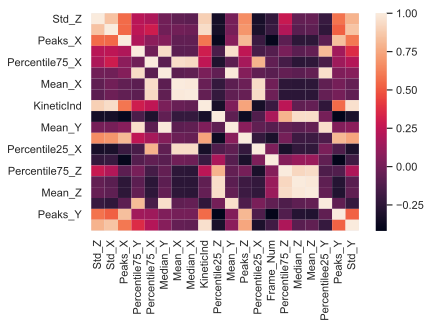

In [31]:
# Drop non-numerical variables
numerical = list(set(df.columns) - set(['ActLabel', 'IsStill', 'Ann']))

# Calculate correlation matrix and plot
corr_matrix = df[numerical].corr() 
sns.heatmap(corr_matrix)

We see that many features are dependent variables between each other. Highly correlated feature affect specific models in different ways and to varying extents:
- For __linear models__ (e.g., linear regression or logistic regression), multicolinearity can yield solutions that are  varying and numerically unstable.
- __Random forests__ can be good at detecting interactions between different features, but highly correlated features can mask these interactions.
- In deep learning models, like __MLPs__ adding correlated features is adding unnecessary information which adds more calculations and parameters to the model.

Also, if we add so much correlated features to the model we may cause the model to consider unnecessary features and we may have curse of high dimensionality problem.

__PCA__ will later be performed to explain the same variance while avoiding multicollinearity.

In [32]:
#features for Model
X = df[numerical]

In [33]:
#Labels for model
Y = df[['IsStill']]

## PCA

In the context of machine learning we can use PCA to reduce the dimension of input patterns. This approach considers removing correlated features by someway (using Single Value Decomposition) and is an unsupervised approach. 

PCA is effected by scale so you need to scale the features in your data before applying PCA. StandardScaler helps us to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of many machine learning algorithms.  

In [34]:
#Scaling to mean 0 and variance 1
sc = StandardScaler()
X_scaled = sc.fit_transform(X) 
X_scaled.shape

(14047, 20)

We will check how much components we should choose. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

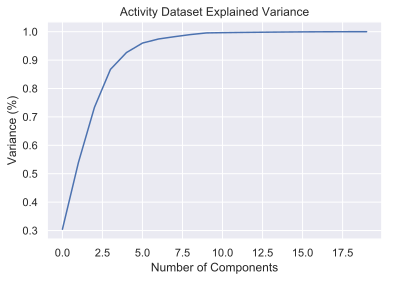

In [35]:
pca = PCA().fit(X_scaled)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Activity Dataset Explained Variance')
plt.show()

This plot tells us that selecting 9 components we can preserve something around 99% of the total variance of the data. It makes sense, we’ll not use 100% of our variance, because it denotes all components, and we want only the principal ones.

With this information, we can implement the PCA for 9 best components:

In [36]:
pca = PCA(n_components=9, random_state=0) #only include first 9 components

principalComponents = pca.fit_transform(X_scaled)

col_names = ['PC ' + str(i) for i in range(1, 10)] 

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = col_names)
principalDf.tail()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9
14042,-1.100470,-0.707267,3.792374,-1.386131,-0.100932,0.867044,0.688500,-0.433703,-0.537197
14043,-1.405324,-0.593940,3.675995,-1.404184,-0.110264,0.948387,0.819086,-0.246201,-0.722033
14044,-1.203008,-0.589148,3.811099,-1.297700,0.324367,0.555407,0.679877,-0.140682,-0.462275
14045,-1.253949,-0.601822,3.831149,-1.396357,-0.042466,0.867504,0.861911,-0.231012,-0.286177
14046,-0.913641,-0.700723,3.623514,-1.412746,0.094342,0.739100,0.879529,-0.190986,-0.742331


In [37]:
finalDf = pd.concat([principalDf, Y], axis=1)
finalDf.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,IsStill
0,1.403295,3.813025,0.914901,-0.064685,-1.631707,-0.223149,-0.397866,-0.219667,0.775929,0
1,0.887228,3.450389,-0.030121,-1.558689,-1.618564,0.040478,-0.772288,0.225865,0.178794,0
2,0.127681,3.470802,-0.233517,-1.315171,-1.162041,-0.095993,-0.906956,-0.787849,0.252082,0
3,0.391916,3.260853,-0.487758,-1.710486,-1.200329,-0.129298,-0.796709,-0.335628,0.503388,0
4,0.345264,3.200550,-0.452546,-1.745411,-1.353417,0.060401,-0.926307,-0.254763,0.499665,0


In [38]:
finalDf.shape

(14047, 10)

We are going to get a holdout dataset. We are splitting of data with 9 principal components to 70% for train and 30% for test.

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split( 
    principalDf, Y, test_size=0.3, random_state=0)

# 1. Linear model with Stochastic Gradient Descent

Firstly we will check linear model for the task of classification of Still Patient position and Positions during Activity.


__Stochastic Gradient Descent (SGD)__ is an extension of gradient descent algorithm and it is a method of generalisation beyond the training set. SGD is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.

The class __SGDClassifier__ implements a plain stochastic gradient descent learning routine. The concrete loss function will be gathered using Grid Search for model tunning later.

We will use Stochastic Gradient Descent for optimization. SGD can converge faster than classic Gradient Descent training because it performs updates more frequently.  

The advantages of Stochastic Gradient Descent are:

 - Efficiency.
 - Ease of implementation (lots of opportunities for code tuning).

__Model generating__

In [40]:
classifier = SGDClassifier(random_state = 0) #model with no params

__Grid generating__

In [41]:
classifier.get_params().keys() #all available feaures to optimize

dict_keys(['alpha', 'average', 'class_weight', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'verbose', 'warm_start'])

In [42]:
parameters_grid = {
    'loss' : ['hinge', 'log', 'squared_hinge', 'squared_loss'], #loss functions 
    'penalty' : ['l1', 'l2'], #regularization
    'n_iter' : range(5,10), #number of iterations
    'alpha' : np.linspace(0.0001, 0.001, num = 5), #reqularization constant
}

As cross-validator we will use __StratifiedShuffleSplit__ because we have __unbalanced__ data and we want to focus on the proper fraction of positive class in validation set on each step of cross-validation.

In [43]:
cv = StratifiedShuffleSplit(n_splits=10, 
                            test_size = 0.3, 
                            random_state = 0)
cv.get_n_splits(X_train, Y_train)

10

__Getting best parameters using Grid Search__

__F1 metric__ is the harmonic average of the precision and recall and we will use it for our tunning to consider imbalanced data.

In [44]:
grid_cv = GridSearchCV(classifier, parameters_grid, scoring = 'f1', cv = cv)

In [45]:
%%time
grid_cv.fit(X_train, Y_train)

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using 

CPU times: user 31.5 s, sys: 5.55 s, total: 37 s
Wall time: 33.6 s


/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_it

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'loss': ['hinge', 'log', 'squared_hinge', 'squared_loss'], 'penalty': ['l1', 'l2'], 'n_iter': range(5, 10), 'alpha': array([0.0001 , 0.00032, 0.00055, 0.00078, 0.001  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [46]:
grid_cv.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=9,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)

Our best estimator has such parameters:

    - alpha=0.001 - reqularization constant
    - loss - hinge - loss function, (soft-margin) linear Support Vector Machine 
    - penalty - l2 - regularization
    - n_iter=9


In [47]:
print("Best sore: ", grid_cv.best_score_)
print("Best model parameters: ", grid_cv.best_params_)

Best sore:  0.8994756234584803
Best model parameters:  {'alpha': 0.001, 'loss': 'hinge', 'n_iter': 9, 'penalty': 'l2'}


__Evaluation__

Let's look on the confusion matrix to understand which errors does the algorithm make.

[[3233  168]
 [  26  788]]


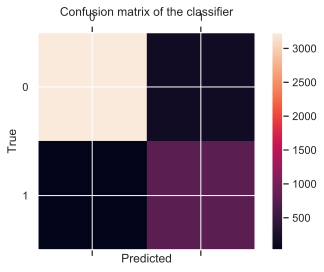

In [48]:
labels = [0, 1]
cm = metrics.confusion_matrix(Y_test, grid_cv.best_estimator_.predict(X_test), labels)
print(cm)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We will check a number of metrics for the model accuracy:

 - F1-score is the harmonic average of the precision and recall and is good in assessing imbalanced data.
 - precision and recall
 - The ROC-AUC metric is showed an area under the curve obtained by ROC curve. The ROC-AUC metrics can vary in range of [0, 1], where 1 score tells that the classifier has perfect prediction ability and never mistakes, 0.5 score is totally random guessing and score below 0.5 means that if we invert result (turns prediction of 0 into 1 and vise versa) we actually get the better model than we have now.
 - Matthews Correlation Coefficient is extremely good metric for the imbalanced classification and can be safely used even classes are very different in sizes. it ranges between −1 and 1, where 1 score shows a perfect prediction, 0 equals to the random prediction and −1 indicates total disagreement between predicted scores and true labels’ values.


In [49]:
Y_pred = grid_cv.best_estimator_.predict(X_test)
print("Precision: %s" % metrics.precision_score(y_true=Y_test,
                                               y_pred=Y_pred))
print("Recall: %s" % metrics.recall_score(y_true=Y_test,
                                               y_pred=Y_pred))
print("F1-score: %s" % metrics.f1_score(y_true=Y_test,
                                               y_pred=Y_pred))
print("ROC-AUC: %s" % metrics.roc_auc_score(y_true=Y_test,
                                               y_score=Y_pred))
print("Matthews Correlation Coefficient: %s" % metrics.matthews_corrcoef(y_true=Y_test,
                                               y_pred=Y_pred))

Precision: 0.8242677824267782
Recall: 0.9680589680589681
F1-score: 0.8903954802259887
ROC-AUC: 0.9593308659759704
Matthews Correlation Coefficient: 0.8659643586360755


__Getting full pipeline of all steps required for the model__

We will use Pipeline from _sklearn_ for getting the ordered instructions for raw dataset in future to combine all steps of our classification algorithm. This will be our final model.
Pipeline contains :
- scaling features
- getting 9 principal components
- training our model using this components

In [50]:
#splitting original dataset to features and labels
features = df[numerical]
labels = df[["IsStill"]]

This time we will split __original__ dataset into train and test.

In [51]:
#get 30% of data as holdout dataset
features_train, features_test, labels_train, labels_test = train_test_split( 
    features, labels, test_size=0.3, random_state=0)

In [52]:
#constructing pipeline of steps
pipe_lr = pipeline.Pipeline([
    ('sc', sc),
    ('pca', pca),
    ('clf', grid_cv.best_estimator_)
])

In [53]:
#fitting algorithm
pipe_lr.fit(features_train, labels_train)

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=9, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_...lty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False))])

In [54]:
label_pred = pipe_lr.predict(features_test)

In [55]:
#checking on of metrics
print("Matthews Correlation Coefficient: %s" % metrics.matthews_corrcoef(y_true=labels_test,
                                               y_pred=label_pred))

Matthews Correlation Coefficient: 0.8668022248181327


We've got even better value of Matthews Correlation Coefficient. The difference between metrics of pipeline and model which we generated so far is because of splitting the original dataset directly, while the previous metric was retrieved after splitting already scaled dataset. This is a random factor in this case - the train-test split matters.

# 2.Gradient Boosting

In this section we will try Gradient Boosting (__XGBoost__) for classification of Still State of patient.

In case of GB, it won't be caught wrong when dealing with very highly correlated input features. Due to its nature, if the number of trees is set to an imaginary infinite value, for two perfectly correlated variables, GB will pickup exactly 50%|50% each features.

The default base learners of XGBoost are tree ensembles. The tree ensemble model is a set of classification and regression trees (CART). Trees are grown one after another ,and attempts to reduce the misclassification rate are made in subsequent iterations.

__Model generating__

In [56]:
cv_params = {'max_depth': [3,5,7], 
             'min_child_weight': [1,3,5], }

#we use 'binary:logistic' for objective for classification problems with probability   
ind_params = {'learning_rate': 0.1, 
              'n_estimators': 100, 
              'seed':0, 'subsample': 0.8,
              'colsample_bytree': 0.8, 
              'objective': 'binary:logistic'} 

#use again f1 score for finding the best model
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                            scoring = 'f1', cv = 5)
optimized_GBM

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Now let’s run our grid search with 5-fold cross-validation and see which parameters perform the best.

In [57]:
optimized_GBM.fit(features_train, labels_train)

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambi

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed 

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed 

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=0.8, verbosity=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

Let’s check our grid scores and best parameters.

In [58]:
print("Grid scores: ", optimized_GBM.grid_scores_)

Grid scores:  [mean: 0.99649, std: 0.00202, params: {'max_depth': 3, 'min_child_weight': 1}, mean: 0.99595, std: 0.00209, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.99568, std: 0.00157, params: {'max_depth': 3, 'min_child_weight': 5}, mean: 0.99649, std: 0.00183, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.99568, std: 0.00157, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.99568, std: 0.00157, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.99649, std: 0.00183, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.99568, std: 0.00157, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.99568, std: 0.00157, params: {'max_depth': 7, 'min_child_weight': 5}]


/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [59]:
print("Best parameters: ", optimized_GBM.best_params_)

Best parameters:  {'max_depth': 5, 'min_child_weight': 1}


In [60]:
print("Best score: ", optimized_GBM.best_score_)

Best score:  0.9964924235552974


In [61]:
gb = optimized_GBM.best_estimator_

We can see that our hyperparameter combinations performed very well and we already beat our target of 0.997 (F1-score) in our cross-validation!

__Analyzing Performance on Test Data__

In [62]:
# Predict probabilities using our test set
y_pred_prob = gb.predict_proba(features_test)
y_pred_prob

array([[9.9988115e-01, 1.1882286e-04],
       [9.9990487e-01, 9.5130461e-05],
       [8.7708235e-04, 9.9912292e-01],
       ...,
       [9.9990487e-01, 9.5130461e-05],
       [9.9986339e-01, 1.3662002e-04],
       [9.9985743e-01, 1.4254964e-04]], dtype=float32)

In [63]:
 # Predict using our test set
y_pred = gb.predict(features_test)
y_pred

/Users/sensogram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([0, 0, 1, ..., 0, 0, 0])

In [64]:
labels_test.T

,9752,10605,7807,321,5133,6578,3744,5160,974,10489,...,11883,13345,11986,7080,7420,9755,3664,1718,10168,1294
IsStill,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


__Getting all metrics__

In [65]:
print("Precision: %s" % metrics.precision_score(labels_test, y_pred))
print("Recall: %s" % metrics.recall_score(labels_test, y_pred))
print("F1-score: %s" % metrics.f1_score(labels_test, y_pred))
print("ROC-AUC: %s" % metrics.roc_auc_score(labels_test, y_pred))
print("Matthews Correlation Coefficient: %s" %
      metrics.matthews_corrcoef(labels_test, y_pred))

Precision: 0.9975369458128078
Recall: 0.995085995085995
F1-score: 0.9963099630996309
ROC-AUC: 0.9972489663756937
Matthews Correlation Coefficient: 0.995429286452196


## Feature importance measures using XGBoost

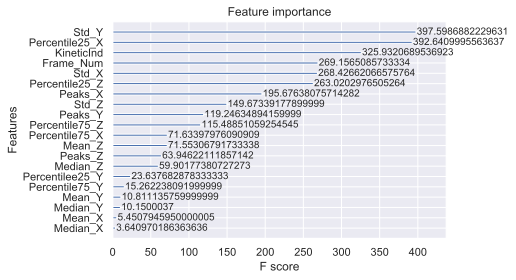

In [66]:
xgb.plot_importance(gb, importance_type='cover')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

__Cover__ importance type option - features leader depends on the number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.

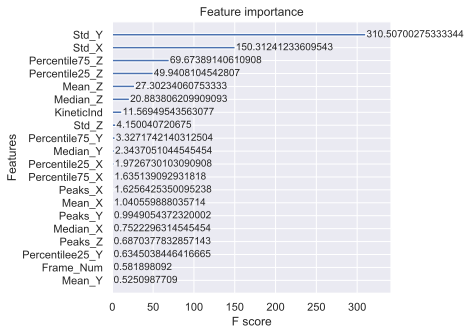

In [67]:
xgb.plot_importance(gb, importance_type='gain')
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

__Gain__ importance type option depends on the average training loss reduction gained when using a feature for splitting.

To our dismay we see that the feature importance orderings are very different for each of the three options provided by XGBoost

The __Tree SHAP method__ is mathematically equivalent to averaging differences in predictions over all possible orderings of the features, rather than just the ordering specified by their position in the tree.
 
SHAP values have guaranteed consistency. Using it we can plot the feature importance for every measurement in our data set. 

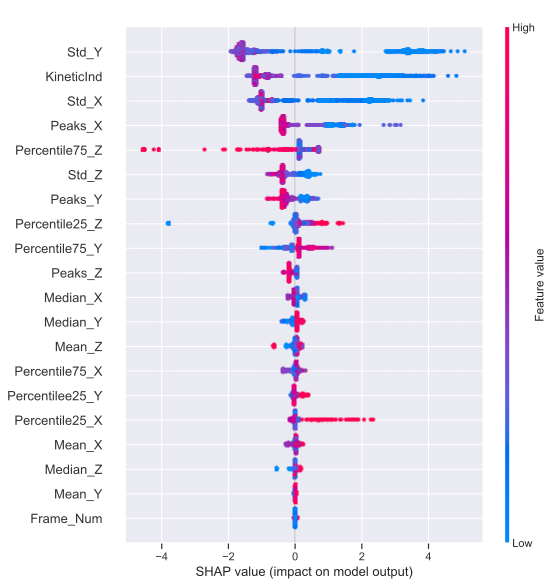

In [68]:
shap_values = shap.TreeExplainer(gb).shap_values(X) #explain every prediction
shap.summary_plot(shap_values, X) #plot these explanations

Every activity measurement has one dot on each row. The x position of the dot is the impact of that feature on the model’s prediction for the measurement, and the color of the dot represents the value of that feature for the measurement. Dots that don’t fit on the row pile up to show density. 

Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model).

The features are sorted by mean(|Tree SHAP|) and so we see the __Std_Y, Kinetic_Ind and Std_X__ are the strongest predictors of labeling signal as recored during still position (sitting/standing).

By plotting the impact of a feature on every sample we can also see important outlier effects. For example, while __Percentile75_Z__ and __Percentile25_X__ are not the most important features globally, it is by far one the most important features for a subset of samples (red color - high feature value).